In [ ]:
import os
import sys
import numpy as np
import pandas as pd

from collections.abc import Callable
from typing import Literal


from sklearn.metrics import accuracy_score, classification_report,confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader

In [ ]:
def fn_plot_torch_hist(hist_df):

    # instantiate figure
    fig, axes = plt.subplots(1,2 , figsize = (15,6))

    # properties  matplotlib.patch.Patch
    props = dict(boxstyle='round', facecolor='cyan', alpha=0.5)

    # columns
    x = hist_df.columns[0]
    y1 = hist_df.columns[1]
    y2 = hist_df.columns[2]
    y3 = hist_df.columns[3]
    y4 = hist_df.columns[4]

    # Where was min loss
    best = hist_df[hist_df[y2] == hist_df[y2].min()]
    best = best.drop_duplicates(subset=y2)
    # pick first axis
    ax = axes[0]

    # Plot all losses
    hist_df.plot(x = x, y = [y1, y2], ax = ax)

    # calculate offset for arroe
    y_min = min(hist_df[y1].min(), hist_df[y2].min())
    y_max = max(hist_df[y1].max(), hist_df[y2].max())
    offset = (y_max-y_min)/10.0

    # little beautification
    txtFmt = "Loss: \n  train: {:6.4f}\n   test: {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y1],
                           hist_df.iloc[-1][y2]) #text to plot

    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.95, txtstr, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)

    # Mark arrow at lowest
    ax.annotate(f'Min: {best[y2].to_numpy()[0]:6.4f}', # text to print
                xy=(best[x].to_numpy(), best[y2].to_numpy()[0]), # Arrow start
                xytext=(best[x].to_numpy()+ offset, best[y2].to_numpy()[0]+offset), # location of text
                fontsize=14,va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor='cyan', shrink=0.05)) # arrow

    # Draw vertical line at best value
    ax.axvline(x = best[x].to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel(x.title())
    ax.set_ylabel(y1.title())
    ax.set_title('Errors')
    ax.grid()
    ax.legend(loc = 'upper left') # model legend to upper left

    # pick second axis
    ax = axes[1]

    # Plot accuracies
    hist_df.plot(x = x, y = [y3, y4], ax = ax)

    # little beautification
    txtFmt = "Accuracy: \n  train: {:6.4f}\n  test:  {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y3],
                           hist_df.iloc[-1][y4]) #text to plot

    # calculate offset for arroe
    y_min = min(hist_df[y3].min(), hist_df[y4].min())
    y_max = max(hist_df[y3].max(), hist_df[y4].max())
    offset = (y_max-y_min)/10.0

    # place a text box in lower middle in axes coords
    ax.text(0.3, 0.2, txtstr, transform=ax.transAxes, fontsize=12,
            verticalalignment='top', bbox=props)

    # Mark arrow at lowest
    ax.annotate(f'Best: {best[y4].to_numpy()[0]:6.4f}', # text to print
                xy=(best[x].to_numpy(), best[y4].to_numpy()[0]), # Arrow start
                xytext=(best[x].to_numpy()- offset, best[y4].to_numpy()[0]-offset), # location of text
                fontsize=14,va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor='cyan', shrink=0.05)) # arrow


    # Draw a vertical line at best value
    ax.axvline(x = best[x].to_numpy(),
               color = 'green',
               linestyle='-.', lw = 3)

    # Labels
    ax.set_xlabel(x.title())
    ax.set_ylabel(y3.title())
    ax.set_title('Accuracies')
    ax.grid();
    ax.legend(loc = 'lower left')

    plt.tight_layout()


In [ ]:
def fn_plot_confusion_matrix(y_true, y_pred, labels):
    '''
    Args:
        y_true: Ground Truth
        y_pred : Predictions
        labels : dictonary
                  {0: 'Goal Keeper',
                  1: 'Defender',
                  2: 'Mid-Fielder',
                  3: 'Forward'}

    '''

    cm  = confusion_matrix(y_true, y_pred)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=labels.values())

    fig, ax = plt.subplots(figsize = (6,6))

    disp.plot(ax = ax, cmap = 'Blues', xticks_rotation = 'vertical', colorbar=False)
    # Disable the grid
    ax.grid(False)

    plt.show();

In [ ]:
print(fn_plot_torch_hist.__doc__)  ##used to access comments from a python file

None


In [ ]:
RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
torch.manual_seed(RANDOM_STATE)


EPOCHS = 50 # number of epochs

ALPHA = 0.001 # learning rate
TEST_SIZE = 0.2
BATCH_SIZE=32
input_shape = 784

# parameters for Matplotlib
params = {'legend.fontsize': 'medium',
          'figure.figsize': (15, 10),
          'axes.labelsize': 'medium',
          'axes.titlesize':'large',
          'xtick.labelsize':'medium',
          'ytick.labelsize':'medium'
         }

plt.rcParams.update(params)

CMAP = plt.cm.coolwarm
plt.style.use('seaborn-v0_8-darkgrid') # plt.style.use('ggplot')

In [ ]:
train_df = pd.read_csv("fashion-mnist_train.csv")
test_df = pd.read_csv("fashion-mnist_test.csv")
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
class_labels = {0 : 'T-shirt/top',
          1 : 'Trouser',
          2 : 'Pullover',
          3 : 'Dress',
          4 : 'Coat',
          5 : 'Sandal',
          6 : 'Shirt',
          7 : 'Sneaker',
          8 : 'Bag',
          9 : 'Ankle boot'
          }

In [ ]:
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:

#implement dataset class
class FashionDS(Dataset):

  def __init__(self,
               dataframe:pd.DataFrame,
               device:str= device,
               ):
    self.df=dataframe
    self.device=device

    self.labels=self.df['label'].to_numpy()
    X=self.df.drop('label',axis=1).to_numpy()

    self.features = X/255.  #Because it is a image datset


  def __len__(self):
    return len(self.features)

  def __getitem__(self,index):
    #Extract features and label from dataframe row
    features=self.features[index]
    label=self.labels[index]

    #convert to Pytorcg tensors
    features=torch.tensor(features,
                          dtype=torch.float32,
                          device=self.device)

    label=torch.tensor(label,
                       dtype=torch.int64,
                       device=self.device)

    return features,label



In [ ]:
train_ds=FashionDS(train_df)

test_ds=FashionDS(test_df)

In [ ]:
train_ds

In [ ]:
train_loader=DataLoader(train_ds,
                        batch_size=BATCH_SIZE,
                        shuffle=True)

test_loader=DataLoader(test_ds,
                        batch_size=BATCH_SIZE,
                        shuffle=True)

In [ ]:
train_loader

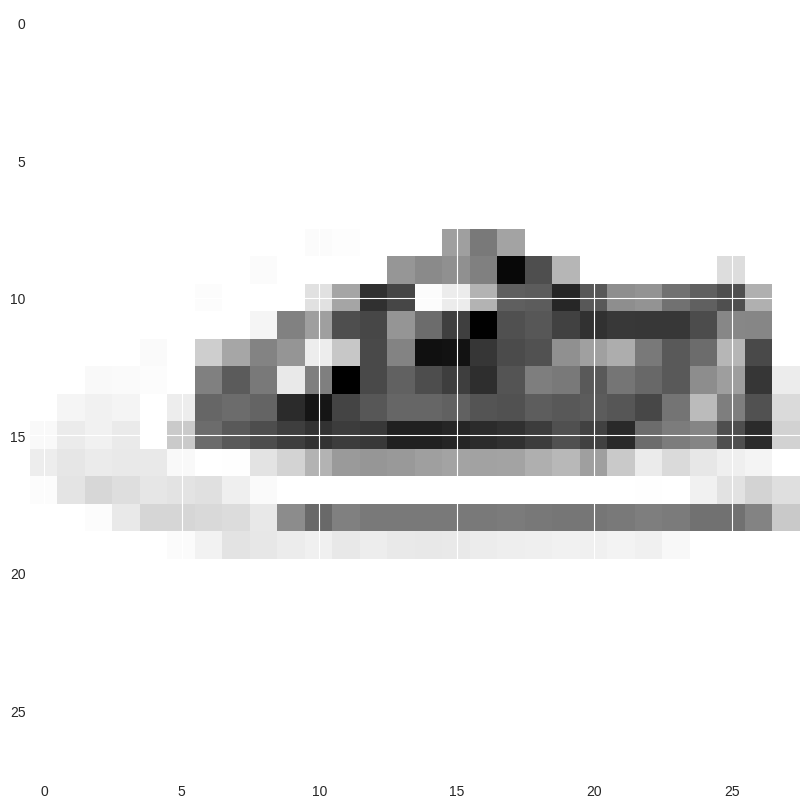

In [ ]:
images, targets = next(iter(train_loader))
images = images.numpy()
plt.imshow(images[0].reshape(28,28),cmap=plt.cm.binary)

In [ ]:
images, targets = next(iter(train_loader))
images = images.cpu().numpy()
targets = targets.cpu().numpy()
targets

array([2, 1, 6, 3, 5, 4, 7, 9, 1, 6, 3, 6, 7, 1, 4, 3, 1, 4, 0, 7, 2, 5,
       7, 8, 5, 6, 5, 1, 7, 7, 4, 0])

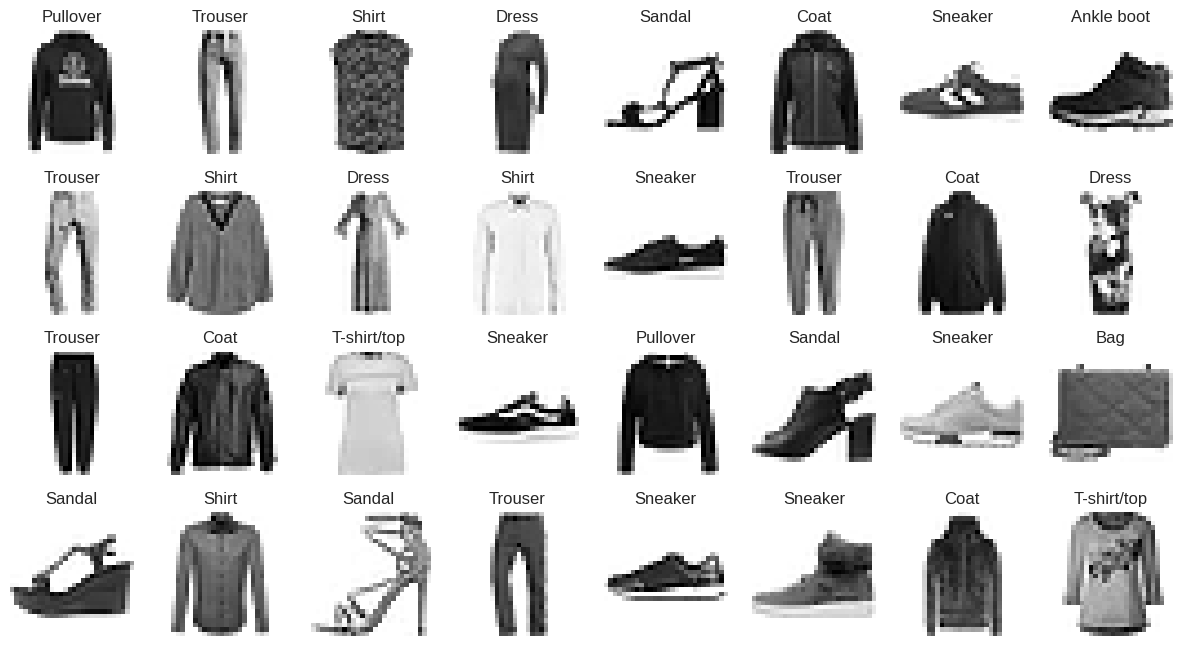

In [ ]:
plt.figure(figsize = (15,8))
for i in range(BATCH_SIZE):
  plt.subplot(4,8,i+1)

  plt.imshow(images[i].reshape(28,28), cmap=plt.cm.binary)

  plt.xticks([])
  plt.yticks([])

  plt.grid(False)
  plt.title(class_labels[targets[i]])

In [ ]:
128/32

4.0

In [ ]:
class Model(nn.Module):
  def __init__(self,input_dim):
    super(Model, self).__init__()
    self.layer1= nn.Linear(input_dim,128)  #784 * 128 /6
    self.activ1=nn.Tanh()
    self.layer2=nn.Linear(128,32)  ##128 * 32/4
    self.activ2=nn.Tanh()
    self.layer3=nn.Linear(32,10)  #32 * 10/3
    self.softmax = nn.LogSoftmax(dim = 1)

  def forward(self,x):
    x=self.layer1(x)
    x=self.activ1(x)
    x=self.layer2(x)
    x=self.activ2(x)
    x=self.layer3(x)
    return self.softmax(x)

net= Model(input_dim=input_shape).to(device)
print(net)

Model(
  (layer1): Linear(in_features=784, out_features=128, bias=True)
  (activ1): Tanh()
  (layer2): Linear(in_features=128, out_features=32, bias=True)
  (activ2): Tanh()
  (layer3): Linear(in_features=32, out_features=10, bias=True)
  (softmax): LogSoftmax(dim=1)
)


In [ ]:
# Define the loss function and optimizer
loss_fn = nn.CrossEntropyLoss() # cross entropy loss

loss, tloss = [],[]
acc, tacc = [],[]
n_epoch = []

optimizer = torch.optim.Adam(net.parameters(), lr=ALPHA)

# Train the model for multiple epochs

for epoch in range(EPOCHS):

    # Training loop
    train_loss = 0.0
    train_acc = 0.0

    for i, data in enumerate(train_loader):

        inputs, labels = data

        optimizer.zero_grad()

        outputs = net(inputs)

        preds = torch.argmax(outputs, dim = 1)

        batch_loss = loss_fn(outputs, labels)
        batch_acc = accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())

        batch_loss.backward()

        optimizer.step()

        train_loss += batch_loss.item() * inputs.size(0)
        train_acc += batch_acc * inputs.size(0)

    train_loss /= len(train_ds)
    train_acc /= len(train_ds)

    loss.append(train_loss)
    acc.append(train_acc)

    # Testing loop
    test_loss = 0.0
    test_acc = 0.0

    with torch.no_grad():

        for data in test_loader:

            inputs, labels = data

            outputs = net(inputs)

            preds = torch.argmax(outputs, dim = 1)

            batch_loss = loss_fn(outputs, labels)

            batch_acc = accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())

            test_loss += batch_loss.item() * inputs.size(0)
            test_acc += batch_acc* inputs.size(0)

        test_loss /= len(test_ds)
        test_acc /= len(test_ds)

        tloss.append(test_loss)
        tacc.append(test_acc)
    n_epoch.append(epoch)

    if epoch%5 == 0:
        print(f'At epoch {epoch} | Loss - train:{train_loss:.4f}, test:{test_loss:.4f} | Acc - train:{train_acc:.4f}, test:{test_acc:.4f}')

At epoch 0 | Loss - train:0.5220, test:0.3985 | Acc - train:0.8190, test:0.8570
At epoch 5 | Loss - train:0.2930, test:0.3145 | Acc - train:0.8909, test:0.8875
At epoch 10 | Loss - train:0.2508, test:0.3106 | Acc - train:0.9065, test:0.8890
At epoch 15 | Loss - train:0.2246, test:0.3233 | Acc - train:0.9157, test:0.8846
At epoch 20 | Loss - train:0.2055, test:0.3148 | Acc - train:0.9224, test:0.8944
At epoch 25 | Loss - train:0.1866, test:0.3298 | Acc - train:0.9307, test:0.8921
At epoch 30 | Loss - train:0.1735, test:0.3427 | Acc - train:0.9356, test:0.8905
At epoch 35 | Loss - train:0.1605, test:0.3547 | Acc - train:0.9407, test:0.8883
At epoch 40 | Loss - train:0.1530, test:0.3742 | Acc - train:0.9425, test:0.8814
At epoch 45 | Loss - train:0.1442, test:0.3654 | Acc - train:0.9457, test:0.8848


In [ ]:
loss_df = pd.DataFrame({'epoch' : n_epoch, 'loss' : loss, 'test_loss': tloss, 'acc' : acc, 'test_acc': tacc})
loss_df.head()

,epoch,loss,test_loss,acc,test_acc
0,0,0.521979,0.398524,0.818983,0.8570
1,1,0.375617,0.350840,0.864933,0.8745
2,2,0.343306,0.349993,0.874083,0.8763
3,3,0.321429,0.349284,0.883533,0.8747
4,4,0.307203,0.348456,0.886833,0.8747


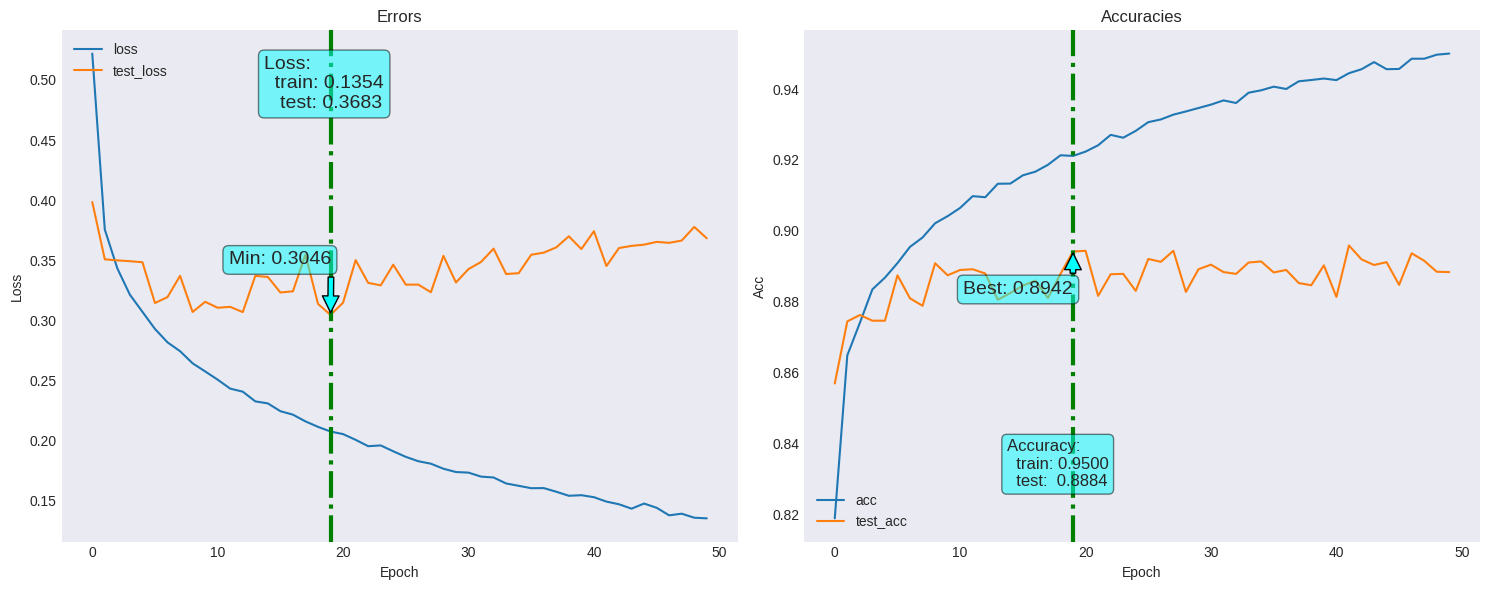

In [ ]:
fn_plot_torch_hist(loss_df)

In [ ]:
y_train = []
y_pred = []
for i, data in enumerate(train_loader):

    inputs, labels = data

    outputs = net(inputs)

    preds = torch.argmax(outputs, dim = 1)

    y_train.extend(labels.cpu().numpy())

    y_pred.extend(preds.cpu().numpy())

In [ ]:
print(classification_report(y_train,y_pred))

              precision    recall  f1-score   support

           0       0.96      0.87      0.91      6000
           1       0.99      1.00      1.00      6000
           2       0.90      0.90      0.90      6000
           3       0.96      0.97      0.96      6000
           4       0.91      0.87      0.89      6000
           5       1.00      1.00      1.00      6000
           6       0.82      0.91      0.86      6000
           7       0.99      1.00      0.99      6000
           8       1.00      0.99      1.00      6000
           9       1.00      0.99      0.99      6000

    accuracy                           0.95     60000
   macro avg       0.95      0.95      0.95     60000
weighted avg       0.95      0.95      0.95     60000



In [ ]:
X = train_df.drop('label',axis = 1).to_numpy()
X = torch.tensor(X, dtype = torch.float32).to(device)
X

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [ ]:
with torch.inference_mode():
  preds = net(X)
  y_pred = preds.argmax(dim = 1)
  y_pred = y_pred.cpu().numpy()
y_pred.shape

(60000,)

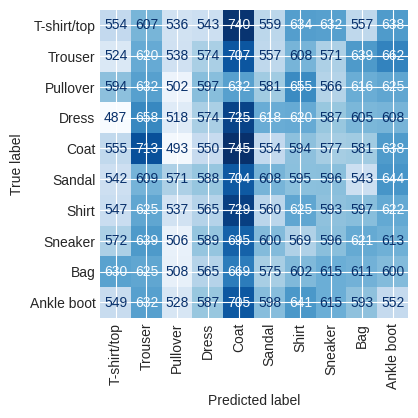

In [ ]:
cm  = confusion_matrix(y_train, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=class_labels.values())

fig, ax = plt.subplots(figsize = (4,4))

disp.plot(ax = ax, cmap = 'Blues', xticks_rotation = 'vertical', colorbar=False)

plt.show();